<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_6/Aula_3_Definindo_a_classifica%C3%A7%C3%A3o_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando conteúdo anterior


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_cadastrados = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/raw/main/Data/clientes_cadastrados.txt")
ids_repetidos = df_cadastrados[df_cadastrados.loc[:,"ID_Cliente"].duplicated(keep = False)].loc[:,"ID_Cliente"]
df_cadastrados_no_rep = df_cadastrados.drop(ids_repetidos.index)

df_cadastrados_no_rep.loc[:,"Anos_empregado"] = df_cadastrados_no_rep.loc[:,"Anos_empregado"].replace(-1000.7, -1)

rend = df_cadastrados_no_rep.loc[:,"Rendimento_Anual"]
rend_mean = rend.mean()
rend_std = rend.std()

lim_sup = rend_mean + (2 * rend_std)
lim_inf = rend_mean - (2 * rend_std) # esse aqui você pode perceber que ficou negativo, e vimos que não há valores negativos nesse dado, então não haverá perdas

index_outliers = [] # lista vazia para for, mesma lógica no R

for index, valor in rend.items():
  if valor > lim_sup or valor < lim_inf:
    index_outliers.append(index)

df_cadastrados_no_out = df_cadastrados_no_rep.drop(index_outliers)

quant_cols = ['Idade', 'Qtd_Filhos', 'Rendimento_Anual', 'Anos_empregado', 'Tamanho_Familia']
cat_cols = ["Genero", "Tem_Carro", "Tem_Casa_Propria", "Categoria_de_renda", "Grau_escolaridade", "Estado_civil",
            "Moradia", "Tem_Celular", "Tem_telefone_trabalho", "Tem_telefone_fixo", "Tem_email", "Ocupacao"]


df_cad_trat1 = df_cadastrados_no_out.drop(["Genero", "Tem_Celular"], axis = 1)

cat_cols.remove("Genero")
cat_cols.remove("Tem_Celular")

## Sessão 1 - Conhecendo a base target

In [3]:
df_aprovados = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/clientes_aprovados.txt")
print(df_aprovados.head())
print(df_aprovados.shape)

   ID_Cliente  Mes_referencia         Faixa_atraso
0     5001711               0    nenhum empréstimo
1     5001711              -1            1-29 dias
2     5001711              -2            1-29 dias
3     5001711              -3            1-29 dias
4     5001712               0  pagamento realizado
(1048575, 3)


In [4]:
df_aprovados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID_Cliente      1048575 non-null  int64 
 1   Mes_referencia  1048575 non-null  int64 
 2   Faixa_atraso    1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [5]:
df_aprovados.loc[:,"ID_Cliente"].value_counts().shape

(45985,)

In [6]:
df_cad_trat1.shape

(425822, 16)

O número de linhas não bate entre os dataframes, o que acontece?
Temos muito mais clientes cadastrados do que clientes aprovados, sendo que podem haver clientes que não foram aprovados ou nem sequer pediram. Na prática, o número de clientes aprovados corresponde ao número de clientes com cartão de crédito.

In [7]:
df_aprovados.query('ID_Cliente == 5001712') # pegando 5001712 de exemplo apenas
# o - no mes de referência é relativo ao passado do mês atual

,ID_Cliente,Mes_referencia,Faixa_atraso
4,5001712,0,pagamento realizado
5,5001712,-1,pagamento realizado
6,5001712,-2,pagamento realizado
7,5001712,-3,pagamento realizado
8,5001712,-4,pagamento realizado
9,5001712,-5,pagamento realizado
10,5001712,-6,pagamento realizado
11,5001712,-7,pagamento realizado
12,5001712,-8,pagamento realizado
13,5001712,-9,1-29 dias


In [8]:
df_aprovados.query('ID_Cliente == 5001711') # pegando outro numero só como exemplo que eles já conhecem

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias


In [9]:
print(df_aprovados.loc[:,"Faixa_atraso"].unique())

['nenhum empréstimo' '1-29 dias' 'pagamento realizado' '30-59 dias'
 '60-89 dias' '90-119 dias' '120-149 dias' '>150 dias']


## Sessão 2 - Criando medidas auxiliares (para sessão 3 - análise vintage)
O objetivo dessa sessão é converter nossa media de mês de referência e faixa de atraso em uma métrica binária de bom ou mau pagador.

### Esse conteúdo é importado diretamente do material do curso disponível no github:

Como é calculado a abertura de crédito ?

1. Criamos uma variavel para guardar os dados da váriavel **df_aprovados** agrupados por **ID_Cliente**, vamos dar o nome de **df_aprovados_agrupados_ID**, para agrupar usamos o método **groupby**.

2. Depois vamos utilizar o método **apply** para iterar por cada **ID_Cliente**, e vamos utilizar o **lambda** para criar uma lógica, e essa lógica vai ser aplicada em **X**, mas o que é **X** ? **X** vai ser um **DataFrame** composto apenas por linhas de um **ID** por vez, a logíca que vai ser aplicada é calcular, através da função **min**, o menor valor da coluna **Mes_referencia**.

3. o retorno dessa função **apply** vai ser uma **Series** de tamanho igual a quantidade de clientes que temos e vai guardar o menor valor **Mes_referencia** de cada cliente, vamos salvar isso na váriavel **ser_abertura**.

In [10]:
df_aprovados_agrupados_ID = df_aprovados.groupby('ID_Cliente')
srs_abertura = df_aprovados_agrupados_ID.apply(lambda x: min(x['Mes_referencia'])) # srs == series
srs_abertura.name = 'Abertura'
srs_abertura

ID_Cliente
5001711    -3
5001712   -18
5001713   -21
5001714   -14
5001715   -59
           ..
5150482   -28
5150483   -17
5150484   -12
5150485    -1
5150487   -29
Name: Abertura, Length: 45985, dtype: int64

Por exemplo, isso significa que o cliente 5001711 abriu a conta há 3 meses atrás, o 5001712 há 18 e assim por diante. Vamos conferir:

In [11]:
df_aprovados.query('ID_Cliente == 5001711').shape # são 4 linhas porque o primeiro é o mês de referência

(4, 3)

In [12]:
df_aprovados.query('ID_Cliente == 5001712').shape # são 19 linhas porque o primeiro é o mês de referência

(19, 3)

Fazendo MERGE para incluir essa nova coluna.
Lembrando que o df_aprovados_agrupados foi apenas um passo intermediário, provavelmente para garantir que não tem nenhum ID que aparece em outro lugar no dataframe.

In [13]:
df_aprovados = df_aprovados.merge(srs_abertura, on = "ID_Cliente")
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura
0,5001711,0,nenhum empréstimo,-3
1,5001711,-1,1-29 dias,-3
2,5001711,-2,1-29 dias,-3
3,5001711,-3,1-29 dias,-3
4,5001712,0,pagamento realizado,-18


Como é calculado o ultimo mês do crédito ?

1. Novamente usamos a váriavel **df_aprovados_agrupados_ID**.

2. Depois vamos utilizar o método **apply** para iterar por cada **ID_Cliente**, e vamos utilizar o **lambda** para criar uma lógica, e essa lógica vai ser aplicada em **X**, mas o que é **X** ? **X** vai ser um **DataFrame** composto apenas por linhas de um **ID** por vez, a lógica que vai ser aplicada é calcular, através da função **max**, o maior valor da coluna **Mes_referencia**.

3. o retorno dessa função **apply** vai uma **Serie** de tamanho igual a quantidade de clientes que temos e vai guardar o maior valor **Mes_referencia** de cada cliente, vamos salvar isso na váriavel **srs_final**.

(Basicamente o processo contrário)

In [14]:
srs_final = df_aprovados_agrupados_ID.apply(lambda x: max(x['Mes_referencia']))
srs_final.name = 'Final'
srs_final

ID_Cliente
5001711     0
5001712     0
5001713     0
5001714     0
5001715     0
           ..
5150482   -11
5150483     0
5150484     0
5150485     0
5150487     0
Name: Final, Length: 45985, dtype: int64

In [15]:
df_aprovados = df_aprovados.merge(srs_final, on = "ID_Cliente")
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final
0,5001711,0,nenhum empréstimo,-3,0
1,5001711,-1,1-29 dias,-3,0
2,5001711,-2,1-29 dias,-3,0
3,5001711,-3,1-29 dias,-3,0
4,5001712,0,pagamento realizado,-18,0


Adicionando a diferença entre final e abertura - Período de tempo em que o cliente possui histórico de crédito

In [16]:
df_aprovados.loc[:,'Janela'] = df_aprovados.loc[:,'Final'] - df_aprovados.loc[:,'Abertura']
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela
0,5001711,0,nenhum empréstimo,-3,0,3
1,5001711,-1,1-29 dias,-3,0,3
2,5001711,-2,1-29 dias,-3,0,3
3,5001711,-3,1-29 dias,-3,0,3
4,5001712,0,pagamento realizado,-18,0,18


Adicionando o MOB - Month on Book - mês de referência menos abertura

In [17]:
df_aprovados.loc[:,'MOB'] = df_aprovados.loc[:,'Mes_referencia'] - df_aprovados.loc[:,'Abertura']
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB
0,5001711,0,nenhum empréstimo,-3,0,3,3
1,5001711,-1,1-29 dias,-3,0,3,2
2,5001711,-2,1-29 dias,-3,0,3,1
3,5001711,-3,1-29 dias,-3,0,3,0
4,5001712,0,pagamento realizado,-18,0,18,18


Converter a faixa de atraso para uma variável numérica categórica e não string:

In [18]:
# criando dicionário 
dict_faixa_atraso_ind ={'nenhum empréstimo': 0, 'pagamento realizado': 1,
                        '1-29 dias': 2, '30-59 dias': 3, '60-89 dias': 4,
                        '90-119 dias': 5, '120-149 dias': 6, '>150 dias': 7}

In [19]:
df_aprovados.loc[:,'Ind_Faixa_atraso'] = df_aprovados.loc[:,"Faixa_atraso"].map(dict_faixa_atraso_ind)
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,Ind_Faixa_atraso
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


Como é definido a coluna **Mau** para atrasos maiores que 60 dias ?

1.  Vamos utilizar o método **apply** para iterar por cada linha do dataframe **df_aprovados**, e vamos utilizar o **lambda** para criar uma lógica, e essa lógica vai ser aplicada em **X**, mas o que é **X** ? **X** vai ser um **DataFrame** composto apenas por uma linha de registro, a logíca que vai ser aplicada é um **if** que se a coluna **Ind_Faixa_atraso** tiver o valor maior que **3**, indicando que existe um **atraso maior que 60 dias**, retorna **1** e **0** caso o contrario.

2. o retorno dessa função **apply** vai uma **Serie** e vai guardar **1** representando que aquele cliente foi um mau pagador naquele periodo ou **0** caso o cliente não tenha sido o mau pagador, vamos salvar estes valores em uma nova coluna chamada **Mau**.

In [20]:
df_aprovados.loc[:,'Mau'] = df_aprovados.apply(lambda x: 1 if x['Ind_Faixa_atraso'] > 3 else 0, axis = 1) # atentar para o fato do método .loc não funcionar dentro do lambda?
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,Ind_Faixa_atraso,Mau
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


## Sessão 3 - Análise Vintage

Agrupar o dataframe a partir do ID

Como é definido as informações calculadas por ID ?

1. Primeiro vamos utilizar os colchetes para ter apenas as colunas de interesse **ID_Cliente ,Abertura , Final, Janela** e o que essas colunas tem de especial é que elas tem os mesmo valores para um determinado ID (cliente) idependente do periodo.

2. Depois utilizamos novamente o groupby para unir as linhas com o mesmo ID e utilizamos tambem o apply para aplicar uma logica em cada ID e essa logica vai ser pega o primeiro registro **X.iloc[0]**, lembra que disse que essas colunas tinham o mesmo valor sempre, então podemos pegar qualquer uma, no caso optei pela primeira.

3. Por fim usamos o **reset_index** para o nosso **ID** voltar a ser uma coluna e salvamos esse novo DataFrame na váriavel **df_aprovados_ID**

In [21]:
df_aprovados_ID = df_aprovados.loc[:,('ID_Cliente', 'Abertura', 'Final', 'Janela')].groupby('ID_Cliente').apply(lambda x: x.iloc[0]).reset_index(drop = True)
df_aprovados_ID.head()

,ID_Cliente,Abertura,Final,Janela
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


Como calcular a quantidade clientes por mês de abertura de crédito ?

1. Primeiro utilizamos o **groupby** no nosso DataFrame, **df_aprovados_ID**, na coluna de **Abertura**, o que isso faz é unir todos os clientes de acordo com a época que a conta foi aberta.

2. O proximo passo foi usar a método **apply** que vai iterar por todos valores de abertura de conta e aplicar a nossa função **lambda**, está por sua vez vai acessa a coluna **ID_Cliente** e aplicar o método **count**, na pratica o que vamos ter é a quantidade clientes de clientes que abriram contas naquele determinado valor de abertura.

3. Por fim vamos utilizar o **reset_index** para recuperarmos a coluna **Abertura**

In [22]:
df_denominador = df_aprovados_ID.groupby('Abertura').apply(lambda x: x['ID_Cliente'].count()).reset_index()
df_denominador.columns = ['Abertura', 'Qtd_Clientes']
df_denominador.head()

,Abertura,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


Como calcular a quantidade clientes considerando Abertura e MOB ?

1. Mesma logica da operação anterior, mudando apenas que agora que utilizamos o **groupby** no nosso DataFrame, **df_aprovados_ID**, na coluna de **Abertura** e na **MOB**, o que isso faz é unir todos os clientes de acordo com a época que a conta foi aberta e o mês no livro.

In [23]:
df_vintage = df_aprovados.groupby(['Abertura', 'MOB']).apply(lambda x: x['ID_Cliente'].count()).reset_index()
df_vintage.columns = ['Abertura', 'MOB', 'Qtd_Clientes']
df_vintage.head()

,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403


Podemos ler como: 
linha 0 - há sessenta meses atrás 415 clientes estavam abrindo crédito
linha 1 - há sessenta meses atrás 414 clientes estavam com crédito aberto há um mês
linha 2 - há sessenta meses atrás 410 clientes estavam com crédito aberto há 2 meses
etc

Agora vamos começar a estrtura da DataFrame Vintage.

1. Vamos utilizar o **merge** para unir o **df_vintage**, colunas **Abertura** e o **df_denominador**, utilizando a coluna **Abertura** para unir as informações.

2. Salvamos esse novo DataFrame na váriavel **df_vintage**

In [24]:
df_vintage = pd.merge(df_vintage.loc[:,('Abertura', 'MOB')], df_denominador, on = ['Abertura'], how = 'left')
df_vintage

,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


Calculando a taxa de maus considerando Abertura e MOB

1. Vamos precisar primeiro criar uma coluna nova no DataFrame **df_vintage**, chamada **Qtd_Mau** e ela vai armazenar a quantidade de clientes maus em um determinado periodo.

2. Utilizamos o **np.nan** para preencher essa coluna apenas com valores nulos

3. Agora vamos utilizar um **for** para iterar por todas os possiveis meses de **Abertura**, que vão de -60 até 0.

4. Tambem vamos precisa criar uma lista para armazenar os ids que cumprirem os requisitos, classificado como mau e ter MOB igual a i e Abertura igual a j, vamos chamar essa lista de **ls**.

5. Agora precisamos de segundo **for** para iterar pelas possibilidades de MOB, que vão de 0 até 60.

6. Vamos utilizar o **query** para filtrar os apenas os IDs que forem classificados como mau e ter MOB igual a i e Abertura igual a j, transformar em lista com **list** e salvamos na variavel **due**.

7. Vamos unir a lista **due** com a lista **ls** utilizando o método **extend**.

8. Utilizando o **set** vamos garantir o ID apareça apenas uma vez e o **len** para calcular a quantidade de IDs unicos. Salvamos esse valor na coluna **Qtd_Mau** na linha de MOB igual a i e Abertura igual a j.

9. Depois de percorrer todas as combinações de MOB e Abertura vamos dividir a quantidade de Ids Mau pela quantidade de Clientes e salvamos esses valores em uma nova coluna chama **Taxa_de_Mau**.

In [25]:
import numpy as np

In [26]:
df_vintage['Qtd_Mau'] = np.nan

for j in range(-60,1):
    ls = []
    for i in range(0,61):
        due = list(df_aprovados.query('Mau == 1 and MOB == @i and Abertura == @j')['ID_Cliente'])
        ls.extend(due)
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Abertura'] == j), 'Qtd_Mau'] = len(set(ls))
        
df_vintage['Taxa_de_Mau']  = df_vintage['Qtd_Mau'] / df_vintage['Qtd_Clientes']
df_vintage     

,Abertura,MOB,Qtd_Clientes,Qtd_Mau,Taxa_de_Mau
0,-60,0,415,0.0,0.000000
1,-60,1,415,0.0,0.000000
2,-60,2,415,0.0,0.000000
3,-60,3,415,0.0,0.000000
4,-60,4,415,0.0,0.000000
...,...,...,...,...,...
1886,-2,1,771,0.0,0.000000
1887,-2,2,771,1.0,0.001297
1888,-1,0,686,0.0,0.000000
1889,-1,1,686,0.0,0.000000


In [27]:
df_vintage_pivot = df_vintage.pivot(index = 'Abertura',
                                    columns = 'MOB',
                                    values = 'Taxa_de_Mau')
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Abertura,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.003432,0.003432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Para construir esse gráfico geramos uma lista valores de 0 até 60.

2. Essa lista é necessaria para filtrar as colunas e depois utilizar o **T** (transpose).

3. Por fim utilizamos o **iloc** para melhorar a visualização, filtrando apenas algumas datas de aberturas.

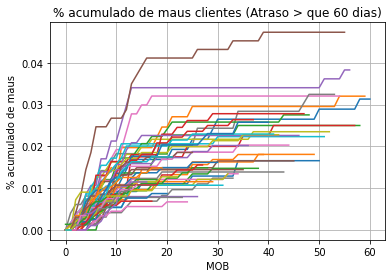

In [28]:
lst = [i for i in range(0,61)]
df_vintage_pivot[lst].T.plot(legend = False, grid = True, title = '% acumulado de maus clientes (Atraso > que 60 dias)')

plt.xlabel('MOB')
plt.ylabel('% acumulado de maus')
#plt.legend(bbox_to_anchor=(1.2, 1), title='Abertura')
plt.show()

Como interpretar esse gráfico? Há um padrão de estabilização de taxa de maus pagadores por volta dos primeiros meses, em torno de um ano. Independente do mês de abertura do crédito, a taxa de maus vai se estabilizar nesse período de tempo.

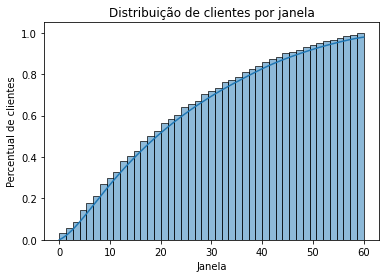

In [29]:
sns.histplot(data = df_aprovados_ID, x = 'Janela', cumulative = True, stat = 'density', kde = True)
plt.title('Distribuição de clientes por janela')
plt.xlabel('Janela')
plt.ylabel('Percentual de clientes')
plt.show()

1. Primeiro criamos um dicionario com todas as possiveis faixas de atraso, onde a chave é a descrição da faixa e o valor é o indice da faixa (é como se eu estivesse desdicionarizando só para efeito da análise).

2. Depois utilizamos um **for** para iterar pelo dicionario, para criar uma coluna para cada uma de nossas faixas.

3. Para determinar o valor dessas colunas utilizamos o **apply**, com uma função anônima que vai utilizar a lógica, se o ind da faixa de atraso for maior ou igual que o ind atual classificamos como mau, igual a 1, e caso for menor retornamos 0.

4. Depois de passar por todas as possibilidades o nosso DataFrame de créditos agora vai ter uma nova coluna de Mau para cada faixa de atraso.

In [30]:
dict_intervalo_atraso = {'maior_30_dias': 3, 'maior_60_dias': 4, 'maior_90_dias': 5,
                        'maior_120_dias': 6, 'maior_150_dias': 7}

In [31]:
for chave, valor in dict_intervalo_atraso.items():
  df_aprovados[f'Mau_{chave}'] = df_aprovados.apply(lambda x: 1 if x['Ind_Faixa_atraso'] >= valor else 0, axis=1) # mais de 60
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Final,Janela,MOB,Ind_Faixa_atraso,Mau,Mau_maior_30_dias,Mau_maior_60_dias,Mau_maior_90_dias,Mau_maior_120_dias,Mau_maior_150_dias
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0,0,0,0,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0,0,0,0,0,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0,0,0,0,0,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0,0,0,0,0,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0,0,0,0,0,0


1. Utilizando a mesma logica que utilizamos para calcular a taxa de mau para atrasos de 60 dias, só que agora aplicado a todas as faixas que determinamos.

2. Primeiro criamos um dicionario que vai ser o respoasavel por guardar todas as taxas de mau.

3. Depois armazenamos a quantidade de clientes na variável **id_sum**

4. Utilizando o **for** vamos iterar por cada uma das faixas de atraso do **dict_intervalo_atraso**.

5. Para o nosso calculo primeiro vamos determinar o menor MOB de todos clientes que tiveram classificação mau == 1 e salvar na variavel **df_min_mau**, para isso utilizamos o **query** para pegar apenas as linhas que tem a coluna Mau daquele determinada faixa com o valor igual 1. Depois unimos os dados de cada cliente utilizando o **groupby**, acessamos a coluna **MOB** e por fim utilizamos **min** para pegar o menor valor de **MOB**. (Utilizamos o **reset_index** para tranformar os IDs novamente em coluna)

6. Tambem vamos precisar de um dataframe, **df_mob_taxa_mau**, para salvar as taxa de mau por mob, esse DF vai ter uma coluna de **MOB** variando de 0 até 60 e uma coluna **Taxa_Mau** apenas com valores nulos.

7. Vamos precisar de uma variavel de apoio **lst** para armazenar os IDs.

8. Agora vamos utilizar o segundo **for** que vai iterar por todos os MOB, de 0 até 60.

9. Vamos utilizar a várivel **due** apenas como auxiliar, nela vamos armazenar temporariamente os IDs que forem daquele MOB. Logo em seguinda vamos incluir essa lista de IDs **due** na nossa lista principa **lst**.

10. Agora finalmente vamos armazenar  calcular a taxa de mau, divindo a quantidade de Ids unicos na lista **lst** pela quantidade total de IDs, **id_sum**, vamos salvar esse valor na coluna **Taxa_Mau** na linha de MOB igual a **i**.

11. Depois de calcular todos as taxas, para cada MOB, salvamos a **Series**, **df_mob_taxa_mau['Taxa_Mau']**, no dicionario **dict_taxa_mau** na posição de uma determinada faixa de atraso.

12. Por fim transformamos esse dicionario em um DataFrame **df_taxa_mau**, onde as linhas vão ser os MOB e as colunas as taxas de mau de cada faixa de atraso.

In [32]:
dict_taxa_mau = {}
id_sum = len(set(df_aprovados['ID_Cliente']))

for chave in dict_intervalo_atraso.keys():
  df_min_mau = df_aprovados.query(f'Mau_{chave} == 1').groupby('ID_Cliente')['MOB'].min().reset_index()
  df_mob_taxa_mau = pd.DataFrame({'MOB':range(0,61), 'Taxa_Mau': np.nan})
  lst = []
  for i in range(0,61):
      due = df_min_mau.query('MOB == @i')['ID_Cliente'].to_list()
      lst.extend(due) #cumsum
      df_mob_taxa_mau.loc[df_mob_taxa_mau['MOB'] == i, 'Taxa_Mau'] = len(set(lst)) / id_sum
  dict_taxa_mau[chave] = df_mob_taxa_mau['Taxa_Mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)
df_taxa_mau

,maior_30_dias,maior_60_dias,maior_90_dias,maior_120_dias,maior_150_dias
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348
...,...,...,...,...,...
56,0.116321,0.014483,0.007176,0.005263,0.004219
57,0.116321,0.014483,0.007176,0.005263,0.004219
58,0.116321,0.014505,0.007198,0.005284,0.004241
59,0.116321,0.014505,0.007198,0.005284,0.004241


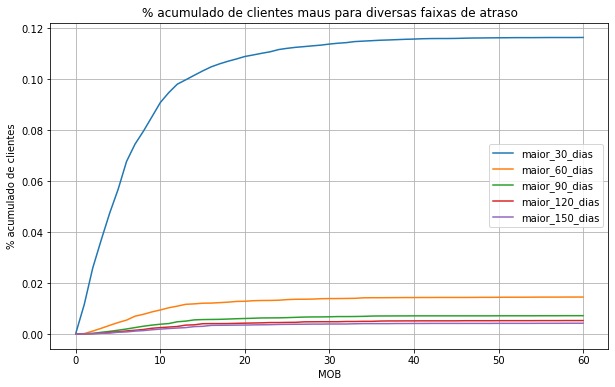

In [33]:
df_taxa_mau.plot(grid = True, title = '% acumulado de clientes maus para diversas faixas de atraso', figsize=(10, 6))
plt.xlabel('MOB')
plt.ylabel('% acumulado de clientes')
plt.show()

Como interpretar esse gráfico? Novamente, o comportamento se estabiliza depois de 12 meses. A curva que considera maus pagadores como > 30 dias indica que não é uma boa medida, porque você acaba considerando todo mundo como maus pagadores.

Nota pessoal: não seria melhor ter começado a análise com esse gráfico? Assim parece que eles pegaram o valor de 60 pra depois testar se é válido...

## Sessão 4 - Definindo o target

Definir se usar atraso > 60 como realmente um mau pagador é efetivo

In [34]:
len(df_aprovados.query('Janela >= 12').groupby('ID_Cliente').count().index) # numero de clientes com janela >= 12

30918

In [35]:
df_aprovados_trat1 = df_aprovados.query('Janela >= 12').copy() # trat1 = tratamento 1
df_aprovados_trat1.shape

(943061, 14)

1. Vamos agrupar os clientes por ID e vamos utilizar o método **apply** para aplicar uma logica para cada ID, essa logica é definida na função **verifica**.

2. Essa função recebe os **registros** de cada cliente, salva todas as faixas de atraso na variavel **lista_status**.

3. Depois utilizamos o **if** para verificar se as faixas de atraso daquele **ID** contem alguma das faixas de atrasos determinadas, caso tenha retorna 1 e caso não retorna 0

4. Depois de aplicar em todos os ID, vamos utilizar o **reset_index** para ter a coluna de ID.

5. No final temos o DataFrame **df_registros_creditos_id**, com a coluna ID e a coluna **Mau**.

In [36]:
def verifica(registros):
  lista_status = registros['Faixa_atraso'].to_list()
  if '60-89 dias' in lista_status or '90-119 dias' in lista_status or '120-149 dias' in lista_status or '>150 dias' in lista_status:
    return 1
  else:
    return 0
  
df_registros_creditos_id = pd.DataFrame(df_aprovados_trat1.groupby('ID_Cliente').apply(verifica)).reset_index()
df_registros_creditos_id.columns = ['ID_Cliente', 'Mau']
df_registros_creditos_id.head()

,ID_Cliente,Mau
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0


In [37]:
df_registros_creditos_id.loc[:,"Mau"].value_counts()

0    30333
1      585
Name: Mau, dtype: int64

Resumindo: definimos que o cliente é considerado mau pagador, somente se tivermos informação sobre sua conta > 12 meses e se o atraso no pagamento for maior que 60 dias. Basicamente, todo o processo até aqui foi para validar se esses critérios são bons (mantenho minha opinião que seria melhor começar testando...)

In [38]:
df_registros_creditos_id.shape

(30918, 2)

In [39]:
df_cad_trat1.shape

(425822, 16)

Combinando a informação sobre bom ou mau pagador na tabela com todas as informações, o df_cad_trat1.

In [40]:
df_registro_clientes_targets = df_cad_trat1.merge(df_registros_creditos_id, on='ID_Cliente')
df_registro_clientes_targets.head()

,ID_Cliente,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado,Mau
0,5008806,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,0,0,0,Seguranca,2.0,3.1,0
1,5008810,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4,0
2,5008811,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4,0
3,5008812,0,1,0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0,0,0,Outros,1.0,-1.0,0
4,5008813,0,1,0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0,0,0,Outros,1.0,-1.0,0


In [41]:
df_registro_clientes_targets['Mau'].value_counts(normalize=True)*100

0    97.726673
1     2.273327
Name: Mau, dtype: float64

### Desafios

#### Desafio 01 - Criar uma tabela com a quantidade de clientes relativo a base por faixa de atraso

Para calcular quantos clientes estão em cada faixa de atraso, devemos definir primeiro como extrair essa informação: a faixa de atraso pode mudar para cada cliente a cada mês. Imagino que o melhor caminho para definir essa estimativa seja agrupar os IDs dos clientes pelo valor máximo de atraso.

In [42]:
df_atraso = pd.DataFrame(df_aprovados.groupby('ID_Cliente').apply(lambda x: max(x['Ind_Faixa_atraso'])).value_counts()).reset_index().rename(columns = {'index': 'Faixa_atraso', 0 : 'Qtd_clientes'}).sort_values(by = 'Faixa_atraso').reset_index(drop = True)
df_atraso

,Faixa_atraso,Qtd_clientes
0,0,4536
1,1,1417
2,2,34682
3,3,4683
4,4,336
5,5,88
6,6,48
7,7,195


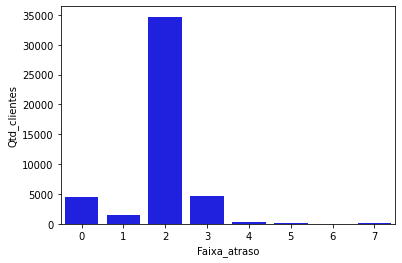

In [43]:
sns.barplot(data = df_atraso, x = 'Faixa_atraso', y = 'Qtd_clientes', color = 'blue') # não precisa de mais uma cor para o mesmo dado
plt.show()

Se lembrarmos do nosso dicionário de conversão de faixas de atraso:

```dict_faixa_atraso_ind ={'nenhum empréstimo': 0, 'pagamento realizado': 1,
                        '1-29 dias': 2, '30-59 dias': 3, '60-89 dias': 4,
                        '90-119 dias': 5, '120-149 dias': 6, '>150 dias': 7}```

Podemos concluir que na nossa base, geralmente os clientes ficam no máximo com 1 mês de atraso, que corresponde à nossa categoria 2.

#### Desafio 02 - Conhecer técnicas para resolver o problema de target desbalanceado

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/